# Tema 29: Pruebas T, parte 2

:::{note}

Esta libreta es la parte 2 del análisis bayesiano de comparación de medias, pero también es la introducción para los modelos lineales

:::

En esta libreta veremos otro método para realizar una comparación de dos medias.

Te sugiero que revises esta [libreta](https://bambinos.github.io/bambi/notebooks/t-test.html) de la documentación de `bambi` para mayor explicación del modelo y un ejemplo diferente.

Cuando utilizamos una prueba t, lo que hacemos es comparar dos medias en dos grupo con la hipótesis $\mu_0 \ne \mu_1$, al hacerlo, utilizamos de forma implícita un modelo lineal, donde comparamos:

$$\mu_i = \beta_0 + \beta_1(i) + \epsilon$$

En este caso $i$ es valor dicotómico de la población en cuestión. Retomando el dataset `palmer penguins`, si comparamos el peso entre la población **Adelie** y la **Chinstrap**, dentro del modelo, $\text{adelie} = 0$ y $\text{chinstrap} = 1$; de tal forma que $i \in {0, 1}$. Al sustituir los índices:

$$\mu_0 = \beta_0 + \epsilon$$ 
$$\mu_1 = \beta_0 + \beta_1 + \epsilon$$

Por lo tanto, para el caso de la hipótesis nula $\mu_0 = \mu_1$, la ecuación de interés es:

$$\beta_0 + \epsilon = \beta_0 + \beta_1 + \epsilon$$

Resolviendo para $\beta_1$:

$$\beta_1 = 0$$

Repasando, en el modelo que contruiremos, la categoría de referencia es "Adelie", $\beta_0$ es la media de  peso de los Adelie y $\beta_1$ es la diferencia de peso entre los Adelie y los Chinstrap.

## Librerías y datos

In [1]:
import bambi as bmb
import arviz as az
import pingouin as pg

data = pg.read_dataset('penguins')
data.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Biscoe,37.8,18.3,174.0,3400.0,female
1,Adelie,Biscoe,37.7,18.7,180.0,3600.0,male
2,Adelie,Biscoe,35.9,19.2,189.0,3800.0,female
3,Adelie,Biscoe,38.2,18.1,185.0,3950.0,male
4,Adelie,Biscoe,38.8,17.2,180.0,3800.0,male


## Definición del modelo

In [2]:
clean_data = data[data['species'] != 'Gentoo'] # solo queremos adelie y chinstrap
model = bmb.Model(
    'body_mass_g ~ species', # también podemos usar la sintaxis de fórmula
    clean_data, # pasamos los datos limpios
    dropna=True # especificamos que queremos retirar los NaN
)
model

Automatically removing 1/220 rows from the dataset.


       Formula: body_mass_g ~ species
        Family: gaussian
          Link: mu = identity
  Observations: 219
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 3710.7306, sigma: 1310.4353)
            species ~ Normal(mu: 0.0, sigma: 2351.7068)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 435.2532)

Ahora ajustaremos los datos al modelo con el método `fit`. Este proceso es costoso, computacionalmente hablando, ya que genera el muestreo de la posterior por el método Montecarlo por cadenas Markov (MCMC). Dependiendo de tu instalación pude que veas algunas advertencias, ignóralas por el momento.

In [3]:
result = model.fit(chains=4)

Initializing NUTS using jitter+adapt_diag...
C:\Users\User\Documents\coding\curso_python\.venv\Lib\site-packages\pytensor\link\c\cmodule.py:2968: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, species]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


Es importante ver que las cadenas parecen no haber encontrado divergencias, lo cual es excelente.
Hagamos diagnóstico de las cadenas, debemos analizar si convergieron adecuadamente. El análisis puede realizarse con `arviz`.

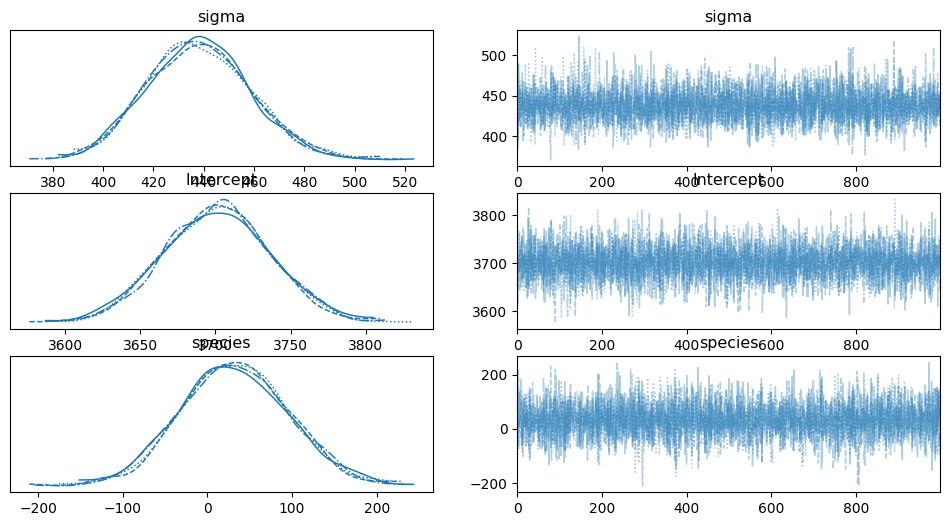

In [4]:
az.plot_trace(result,);

Podemos ver que las cadenas parecen haber convergido ya que las trazas tienen forma de "ruido". Ahora podemos analizar los resultados.

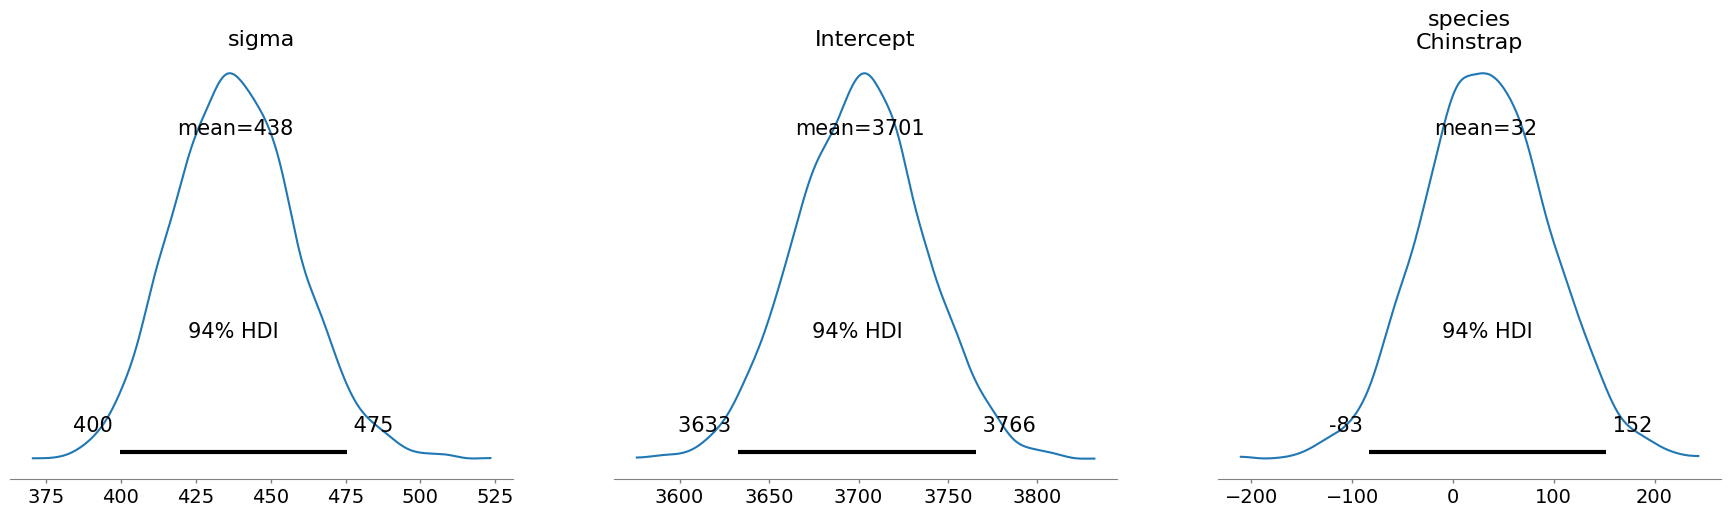

In [5]:
az.plot_posterior(result);

Esto grafica las posteriores, pero en realidad solo nos interesa el grupo de especie.

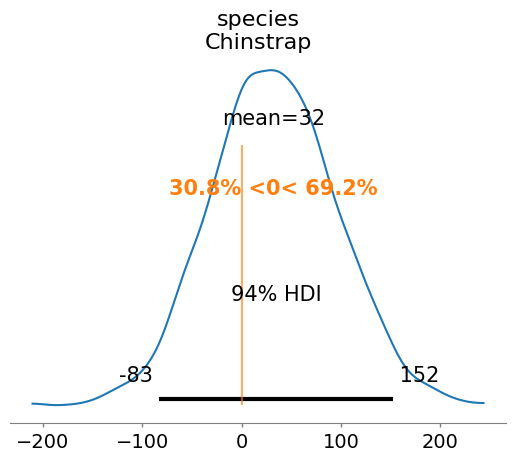

In [6]:
az.plot_posterior(
    result, # el objeto resultado de fit
    var_names="species", # el nombre de la variable que nos interesa
    ref_val=0 # el valor de referencia con que queremos comparar.
);

Podemos ver que efectivamente no parece haber diferencia, ya que el intervalo de credibilidad cruza el cero. Veamoslo en forma de tabla.

In [7]:
az.summary(result)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,438.187,20.559,399.598,475.394,0.268,0.346,5994.0,2779.0,1.0
Intercept,3701.036,35.576,3632.574,3765.734,0.452,0.553,6173.0,3114.0,1.0
species[Chinstrap],32.199,63.543,-83.054,152.023,0.812,1.025,6125.0,3205.0,1.0


Sigma es la diferencia entre las especies, el intercepto es la media de peso para la especie de referencia (Adelie). Bambi tomó el primer valor como el de referencia, es posible especificar el grupo de referencia pero lo veremos en otra lección, en este caso ambos grupos son adecuados. `species[Chinstrap]` es la diferencia en el valor del peso para esta especie. 

En la tabla también podemos ver el valor $\hat{R}=1$ en todos los casos, lo que es importante para la confiabilidad de los resultados.

Podemos ver que el intervalo creible  cruza igualmente por el cero, por lo que podemos rechazar la significancia de la diferencia. Pero calculemos el factor bayes, para ello necesitamos muestear el prior y unirlo a nuestro resultado.


In [8]:
prior = model.prior_predictive() # muestreamos el prior
result.extend(prior) # extendemos el resultado para que contenga el prior
az.bayes_factor(result, 'species') # especificamos la variable de interés

Sampling: [Intercept, body_mass_g, sigma, species]
arviz - WARNING - Posterior distribution has {posterior.ndim} dimensions


{'BF10': np.float64(0.003766522877088962),
 'BF01': np.float64(265.4968608003973)}

Podemos ver que tenemos evidencia muy fuerte a favor de la hipótesis nula.
## Ejercicio
1. Ejecuta este método para comparación de medias con tus propios datos.
2. Compara varias cadenas. Ajusta el modelo con diferente número de chains (por ejemplo, 2 o 8) y analiza si afecta el resultado o la convergencia.
3. Realiza la prueba T comparando el peso de acuerdo al sexo.